In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, List
from typing_extensions import Annotated
import operator

load_dotenv()
import os 

In [2]:
model = ChatOpenAI(
    model_name="mistralai/mistral-7b-instruct",
    openai_api_base="https://openrouter.ai/api/v1",
    openai_api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature=0.7,
)

In [3]:
from pydantic import BaseModel, Field

class Schema(BaseModel):
    feedback: str = Field(description="Detailed feedback for the essay")
    score: int = Field(description="Score out of 10", ge=0, le=10)

str_model = model.with_structured_output(Schema)

In [4]:
class UPSEState(TypedDict):
    essay: str
    language_feedback: str
    clarity_feedback: str
    overall_feedback: str
    analysis_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    improved_essay: str
    max_iterations: int
    avg_score: float
    iteration_count: int
    threshold_score: float

In [5]:
def evaluate_language(state: UPSEState):
    prompt = f"""Analyze the following essay for language quality. Return ONLY a JSON object with 'feedback' and 'score' fields.

Essay: {state['essay']}

Required JSON format:
{{"feedback": "detailed feedback on grammar, clarity, coherence, formal tone, and vocabulary", "score": integer_score_out_of_10}}"""

    output = str_model.invoke(prompt)
    return {'language_feedback': output.feedback, 'individual_scores': [output.score]}

In [6]:
def evaluate_analysis(state: UPSEState):
    prompt = f"""Evaluate the depth of analysis in the following essay. Return ONLY a JSON object with 'feedback' and 'score' fields.

Essay: {state['essay']}

Required JSON format:
{{"feedback": "detailed feedback on analytical depth", "score": integer_score_out_of_10}}"""

    output = str_model.invoke(prompt)
    return {'analysis_feedback': output.feedback, 'individual_scores': [output.score]}

In [7]:
def evaluate_COT(state: UPSEState):
    prompt = f"""Evaluate the clarity of thought in the following essay. Return ONLY a JSON object with 'feedback' and 'score' fields.

Essay: {state['essay']}

Required JSON format:
{{"feedback": "detailed feedback on clarity of thought", "score": integer_score_out_of_10}}"""

    output = str_model.invoke(prompt)
    return {'clarity_feedback': output.feedback, 'individual_scores': [output.score]}

In [8]:
# Function for final summary
def final_evaluation(state: UPSEState):
    prompt = f'Based on the following feedback create a summarized feedback:\nLanguage feedback: {state["language_feedback"]}\nAnalysis feedback: {state["analysis_feedback"]}\nClarity feedback: {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content
    avg_score = sum(state['individual_scores']) / len(state['individual_scores']) if state['individual_scores'] else 0.0
    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [9]:
# Check quality node - this is the key fix!
def check_quality(state: UPSEState):
    """Check quality node that returns state updates, not routing decisions"""
    print(f"🔍 Quality Check: Score = {state['avg_score']:.2f}, Iteration = {state['iteration_count']}")
    
    # This node doesn't return routing info, just processes the state
    # The routing decision is handled by the conditional function
    return {}  # Return empty dict to maintain state

In [10]:
# Conditional function for routing decisions
def should_continue(state: UPSEState) -> str:
    """Determines whether to continue improving or end the workflow"""
    if state['avg_score'] >= state['threshold_score']:
        print(f" Quality threshold met! Average score: {state['avg_score']:.2f}")
        return "end"
    elif state['iteration_count'] >= state['max_iterations']:
        print(f" Max iterations reached ({state['max_iterations']}). Current score: {state['avg_score']:.2f}")
        return "end"
    else:
        print(f" Continuing improvement. Current score: {state['avg_score']:.2f}, Iteration: {state['iteration_count']}")
        return "improve_essay"

In [11]:
def improve_essay(state: UPSEState):
    prompt = f"""You are an expert UPSC essay writer.

Using the following feedback:
- Clarity of Thought: {state["clarity_feedback"]}
- Language Quality: {state["language_feedback"]}
- Analytical Depth: {state["analysis_feedback"]}

Rewrite the essay in a much better way, maintaining the original theme and increasing its effectiveness.

Essay to improve:
{state["essay"]}

Return only the improved essay."""

    improved = model.invoke(prompt).content
    return {
        "essay": improved,
        "iteration_count": state.get("iteration_count", 0) + 1,
        # Reset individual scores for next iteration
        "individual_scores": [],
        "language_feedback": "",
        "clarity_feedback": "",
        "analysis_feedback": "",
        "overall_feedback": ""
    }

In [12]:
graph = StateGraph(UPSEState)

# Add all nodes
graph.add_node('evaluate_COT', evaluate_COT)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('final_evaluation', final_evaluation)
graph.add_node('check_quality', check_quality)
graph.add_node('improve_essay', improve_essay)

# Flow exactly as shown in the diagram
# START -> evaluate_COT  
graph.add_edge(START, 'evaluate_COT')

# evaluate_COT -> evaluate_analysis
graph.add_edge('evaluate_COT', 'evaluate_analysis')

# evaluate_analysis -> evaluate_language
graph.add_edge('evaluate_analysis', 'evaluate_language')

# evaluate_language -> final_evaluation
graph.add_edge('evaluate_language', 'final_evaluation')

# final_evaluation -> check_quality
graph.add_edge('final_evaluation', 'check_quality')

# Conditional edges from check_quality
graph.add_conditional_edges(
    'check_quality',
    should_continue,  # This function determines the routing
    {
        "end": END,
        "improve_essay": "improve_essay"
    }
)

# improve_essay -> evaluate_COT (completing the cycle)
graph.add_edge('improve_essay', 'evaluate_COT')

# Compile the workflow
workflow = graph.compile()

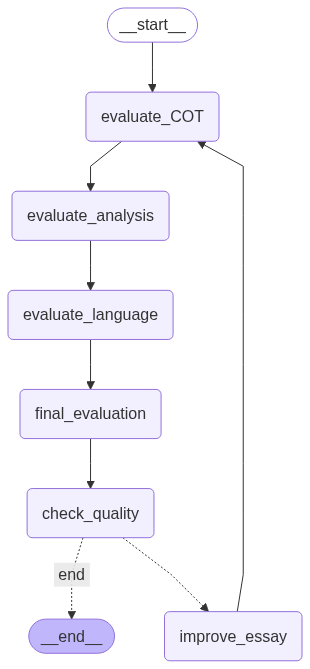

In [13]:
workflow

In [ ]:
if __name__ == "__main__":
    initial_state = {
        'essay': """Artificial Intelligence (AI) is not just a technological breakthrough—it is a strategic imperative for nations in the 21st century. For India, AI presents a historic opportunity to drive inclusive growth, strengthen governance, and position itself as a global digital leader.

India's strengths lie in its vast digital ecosystem, young tech-savvy population, and rich data reserves. Recognizing this, NITI Aayog's #AIForAll initiative identifies key sectors for AI deployment: agriculture, healthcare, education, smart mobility, and infrastructure.

AI is already enhancing public service delivery through:

Predictive analytics in healthcare (e.g., Aarogya Setu)
Crop monitoring via satellite data and ML
Chatbots in citizen services
Facial recognition for law enforcement

However, challenges remain—job displacement, data privacy, algorithmic bias, and lack of regulation demand immediate attention. India's future in AI must balance innovation with ethics, inclusion with efficiency, and automation with accountability.

If harnessed responsibly, AI can transform India into a technology-driven welfare state, empowering citizens and ensuring efficient, transparent, and responsive governance""",
        'language_feedback': "",
        'clarity_feedback': "",
        'overall_feedback': "",
        'analysis_feedback': "",
        'individual_scores': [],
        'improved_essay': "",
        'max_iterations': 3,
        'avg_score': 0.0,
        'iteration_count': 0,
        'threshold_score': 7.0,
    }

    try:
        print(" Starting UPSC Essay Evaluation Workflow...")
        output = workflow.invoke(initial_state)
        
        print("\n" + "="*80)
        print(" FINAL RESULTS")
        print("="*80)
        print(f"Final Average Score: {output['avg_score']:.2f}/10")

        
        print(f"\n Overall Feedback:\n{output['overall_feedback']}")
        print(f"\n Final Essay:\n{output['essay']}")

        
    except Exception as e:
        print(f" Error occurred: {str(e)}")

 Starting UPSC Essay Evaluation Workflow...
 Quality Check: Score = 7.00, Iteration = 0
 Quality threshold met! Average score: 7.00

 FINAL RESULTS
Final Average Score: 7.00/10
Total Iterations: 0

 Overall Feedback:
 The essay showcases a formal tone, clear structure, and appropriate language, including complex terms like 'strategic imperative', 'inclusive growth', and 'algorithmic bias'. However, it could benefit from a more detailed explanation in certain areas, such as specific examples of AI enhancing public service delivery, and addressing challenges faced in India's AI development. The essay could also strengthen its conclusion to emphasize the potential benefits of AI for India.

The analytical depth is moderate, with a clear argument about the strategic importance of AI for India and identification of ways AI is being used to improve public services. However, the essay could delve deeper into the challenges mentioned, including job displacement, data privacy, algorithmic bias,

In [17]:
with open("output.txt", "w", encoding="utf-8") as f:
    f.write(output["essay"] if isinstance(output, dict) else str(output.essay))

